<img style="float: left; width: 220px;" src="images/shutterstock_318255209.jpg">
***
## <font color="grey"> $\quad$ Distinct proliferation rates - Methods </font>
***
$\newcommand{\vct}[1]{\mathbf{#1}}$
$\newcommand{\mtx}[1]{\mathbf{#1}}$
$\newcommand{\e}{\varepsilon}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\minimize}{\mathrm{minimize}\quad}$
$\newcommand{\maximize}{\mathrm{maximize}\quad}$
$\newcommand{\subjto}{\quad\text{subject to}\quad}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\trans}{T}$
$\newcommand{\ip}[2]{\langle {#1}, {#2} \rangle}$
$\newcommand{\zerovct}{\vct{0}}$
$\newcommand{\diff}[1]{\mathrm{d}{#1}}$
$\newcommand{\conv}{\operatorname{conv}}$
$\newcommand{\inter}{{\operatorname{int}}}$

This document provides a detailed derivation of all the results with associated R code.

In [3]:
library(MASS)
library(robustbase)
library(robust)
library(ggplot2)
library(repr)
library(AER)
library(vcd)
library(zoo)
options(repr.plot.width=8, repr.plot.height=3)
library(gridExtra)
#library(deconstructSigs)
#library(SomaticSignatures)`
library(nnls)
library(boot)
library(sfsmisc)
library(stringr)
#library(rebmix)

### <font color="grey">  1. Data preparation</font>

The primary data is based on whole-exome sequences derived from cancer cells of 323 patient samples, taken from the [The Cancer Genome Atlas (TCGA) skin cutaneous melanoma (SKCM)](https://gdc-portal.nci.nih.gov/projects/TCGA-SKCM) database. For each sample and for each of $K=96$ types of single nucleotide substitutions (SNVs) in trinucleotide context, we count the number of times this substitution occurs relative to the abundance of the given context in the exome. In addition, we use whole-genome data of 119 melanoma samples from Australia provided by the [International Cancer Genome Consortium (ICGC)](https://dcc.icgc.org/projects?filters=%7B%22project%22:%7B%22id%22:%7B%22is%22:%5B%22MELA-AU%22%5D%7D%7D%7D).

**TODO (Simon)** Explain how these were derived. In particular also, if there was any normalization in determining the counts.

According to [Alexandrov et al](http://www.nature.com/nature/journal/v500/n7463/full/nature12477.html), the vector counting the number of times each substitution out of a predefined set appears in a sample can be expressed as a non-negative linear combination of **mutation signatures**. More precisely, the mutation alphabet $\Theta$ we consider consists of single nucleotide substitutions in trinucleotide context. The subsitution considered are from Cytosine or Thymine to one of the three other bases, making 6 possible subsitutions in $4\times 4=16$ contexts. The alphabet thus consists of $K=96$ elements. A **mutation catalog** $\vct{m}\in \R^K$ consists of the number of times each of the substitutions occurs within a sample. A mutation catalog can be approximated as non-negative linear combination

\begin{equation*}
  \vct{m} \approx \sum_{i=1}^N e_i \vct{p}_i,
\end{equation*}

where the $\vct{p}_i\in \R^K$ are probability distributions on the alphabet $\Theta$, called mutation signatures. The coefficient $e_i$ is called the **exposure** of sample $i$ to signature $p_i$. 

We work with different mutation signatures.
* The first catalog of mutation signatures that we use is from the [COSMIC Database](http://cancer.sanger.ac.uk/cosmic). Of biggest interest in Melanoma are signatures $1$ and $7$ from this database. Signature $7$ is known to be related to UV exposure.  Signature $1$ is dominated by C>T subsitutions in NpG dinucleotide context, which is believed to be related to the spontaneous deanimation of 5-methylcytosine, and has been observed to accumulate at a constant rate over time in melanoma and some other cancers ([Alexandrov et al](http://www.nature.com/ng/journal/v47/n12/full/ng.3441.html)).
* Besides using the COSMIC signatures, we also use a de novo extraction of mutation signatures using a [hierarchical dirichlet process (HDP)](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process), with samples separated into groups according to whether the mutations occur in the BRAF, NRAS, NF1 genes, or none of these. This new extraction of signatures is based on [Nicola Robert's hdp package](https://github.com/nicolaroberts/hdp/blob/master/vignettes/mutation_signatures.Rmd).

The following three graphs show the profile of COSMIC Signature 1, and its counterpart derived using a HDP from exome and from genome data.

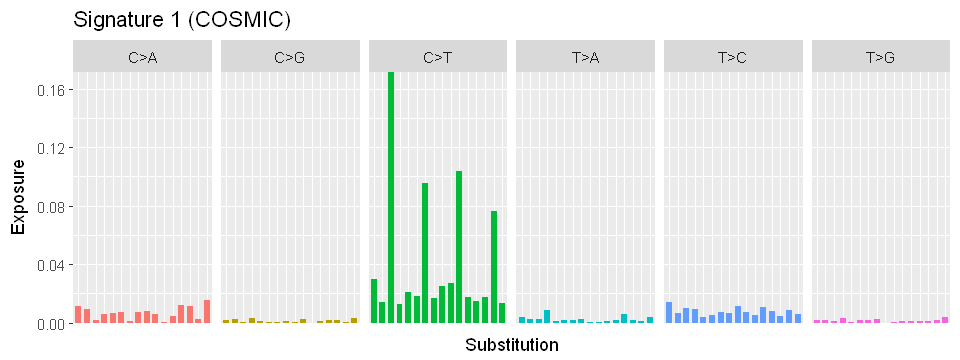

In [49]:
signatures <- read.csv('data/signatures_probabilities.txt', sep="\t")
# Do some preformating for plot
signatures$Context <- paste(substr(signatures$Trinucleotide, 1, 1), substr(signatures$Trinucleotide, 3, 3), sep='')
ggplot(data=signatures, aes(x=Context, y=Signature.1)) +
    geom_bar(stat="identity", aes(fill=Substitution.Type), width=0.7) + facet_wrap(~ Substitution.Type, ncol=6) +
    xlab("Substitution") + ylab("Exposure") +  guides(fill=FALSE) + ggtitle("Signature 1 (COSMIC)") +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + scale_y_continuous(expand = c(0,0))

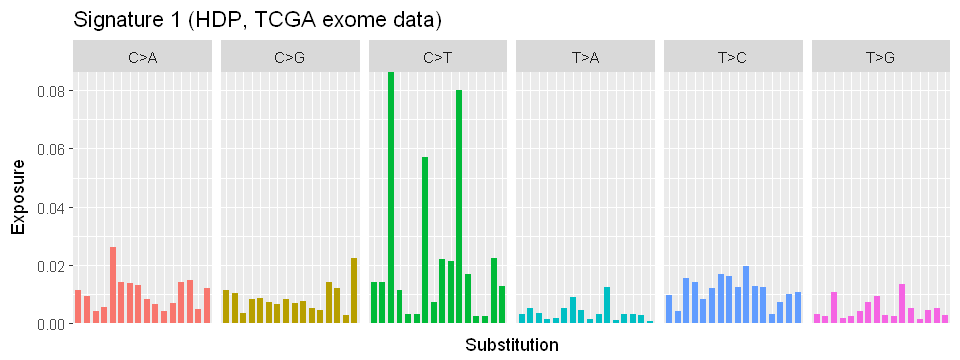

In [50]:
signatures.tcga <- read.csv('data/signatures_tcga.csv', row.names=1)
#colnames(signatures.tcga) <- c('Signature.1', 'Signature.2', 'Signature.3', 'Signature.4', 'Signature.5', 'Signature.6', 'Signature.7', 'Signature.8')
#signatures.tcga <- cbind(signatures[,c(1:3)],signatures.tcga)
# Do some preformating for plot
signatures.tcga$Context <- paste(substr(signatures.tcga$Trinucleotide, 1, 1), substr(signatures.tcga$Trinucleotide, 3, 3), sep='')
ggplot(data=signatures.tcga, aes(x=Context, y=Signature.3)) +
    geom_bar(stat="identity", aes(fill=Substitution.Type), width=0.7) + facet_wrap(~ Substitution.Type, ncol=6) +
    xlab("Substitution") + ylab("Exposure") +  guides(fill=FALSE) + ggtitle("Signature 1 (HDP, TCGA exome data)") +
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + scale_y_continuous(expand = c(0,0))

**Figure.** Bar chart showing the make up of Signature 1 in two different settings.

For the main analysis we use the COSMIC Signature and later on validate the results using the HDP signatures and the ICGC genome data.

For each sample we estimated the the exposure $e_1$ to mutation signature 1 using a the R package desconstructSigs. The extraction follows the following procedure:

1. Select a biologically meaningful subset of $p$ mutation signatures (here, signatures 1, 5, 7, 11 and 17).
2. Normalize each component $m_i$ (=number of mutations of type $i$) by multiplying it with the proportion of occurences of the corresponding trinucleotide in the exome or genome. For example, if we denote by $q_i$ the proportion of trinucleotide $i$ (for example, TCG) occurs in a reference exome or genome, then we replace each entry $m_i$ of the catalog with $q_i m_i$, obtaining a new mutation catalog. 
3. Normalize the resulting catalog by dividing with the total number $m=\sum_{i=1}^K q_im_i$ of (normalized) mutations. This gives a new normalized mutation catalog $\tilde{\vct{m}}$ with the property that $\sum_{i=1}^K \tilde{m}_i = 1$. 
4. Solve a simplex-constrained least squares problem

\begin{equation*}
  \min_{\vct{\epsilon}\in \R^{p}} \left\|\tilde{\vct{m}}-\sum_{i=1}^p \epsilon_i \vct{p}_i\right\|_2^2 \text{ subject to } \epsilon_i\geq 0, 1\leq i\leq p, \text{ and } \sum_{i=1}^p \epsilon_i = 1.
\end{equation*}

The exposure to signature $j$ is then computed as $e_j = \epsilon_j \cdot \left(\sum_{i=1}^K q_i m_i\right)$. 

**TODO** A few things need to be sorted out with respect to normalizations.

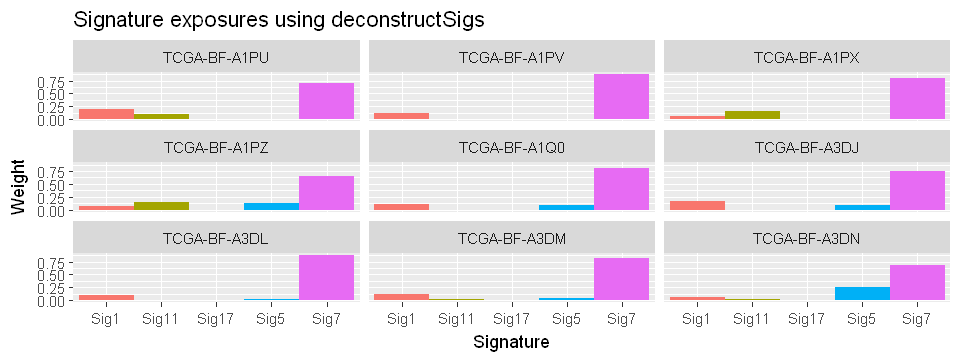

In [179]:
# Extract exposure to mutation signatures of one sample
load("data/tcga.344.sigs.input.RData")
E <- data.frame(row.names = rownames(sigs.input)[1:9])
E[,c('Sig1','Sig5','Sig7','Sig11','Sig17')]=0
for (x in rownames(sigs.input)[1:9]) {
    sample <- whichSignatures(tumor.ref = sigs.input[1:9,],
                              signatures.ref = signatures.cosmic[c('Signature.1',
                                                                   'Signature.5',
                                                                   'Signature.7',
                                                                   'Signature.11',
                                                                   'Signature.17'),],
                              sample.id = x,
                              contexts.needed = TRUE,
                              tri.counts.method = 'default',
                              signature.cutoff = 0)
    E[x,c('Sig1','Sig5','Sig7','Sig11','Sig17')] <- sample$weights[,c('Signature.1',
                                                                      'Signature.5',
                                                                      'Signature.7',
                                                                      'Signature.11',
                                                                      'Signature.17')]
  }
# Show the proportion of mutation signatures for nine samples
d <- data.frame(matrix(nrow=5,ncol=3))
colnames(d) <- c('Sample','Signature','Weight')
i = 1
for (x in rownames(E)) {
    for (y in c('Sig1', 'Sig5', 'Sig7','Sig11','Sig17')) {
        d[i,'Sample'] <- x
        d[i,'Signature'] <- y
        d[i,'Weight'] <- E[x,y]
        i = i+1
    }
}
ggplot(d, aes(x = Signature, y=Weight, fill=as.factor(Signature))) + geom_bar(stat="identity", width = 1) + 
    guides(fill=FALSE) + #scale_x_discrete(labels = c("1","5","7","11","17"))+
    facet_wrap(~ as.factor(Sample), ncol=3, nrow=3) + ggtitle("Signature exposures using deconstructSigs")

**Figure.** Proportion of signature 1 and signature 7 in nine different samples.

We added information on whether the sample had mutations in BRAF, NRAS, NF1 or none of these genes. Five samples had both BRAF and NRAS mutations. They likely aquired the NRAS mutations as a consequence of targeted therapy, and were excluded from the study. There were $50$ samples with both BRAF/NRAS and NF1 mutations, and they were classified as BRAF or NRAS, respectively. Overall, $163$ samples are BRAF, $88$ samples NRAS, $21$ samples NF1, and the remaining $51$ samples were classified as triple wild type (W3).

For a subset of 258 samples, additional information on the MC1R phenotype (whether an individual has two, one or no 'R' alleles) was included. This information was taken from the supplementary material of [Robles-Espinoza et al](http://www.nature.com/articles/ncomms12064).

The data was reduced from a larger data set of $330$ samples by removing $7$ outliers. The idea here is that if a random variable $X$ is Poisson distributed with mean $\lambda$, then $2\sqrt{X}$ is approximately normally distributed with mean the median of $2\sqrt{X}$. We can then reject entries as outliers if the are bigger than the median $+3$. While this is a good approximation for large $\lambda$, it gives a conservative rule for rejecting outliers even for small $\lambda$.

The prepared data is summarized in a file 'tcga_4class.Rdata'. In addition, we computed means, robust means (based on robGlm) and medians for each age, and for each age restricted to the BRAF and NRAS samples.

In [4]:
#data <- read.csv('data/tcga_4class.csv', header=TRUE)
load('data/tcga_4class.Rdata')
data <- sigdata.tcga
dim(data)
data.tcga <- data
load('data/icgc_4class.Rdata')
data.icgc <- sigdata.icgc
dim(data.icgc)

[1] 323   9

[1] 119   7

In [5]:
cat("TCGA data: \n")
cat("BRAF:", nrow(subset(data, Cohort=="BRAF")), "\n")
cat("NRAS:", nrow(subset(data, Cohort=="NRAS")), "\n")
cat("NF1:", nrow(subset(data, Cohort=="NF1")), "\n")
cat("Triple wild:", nrow(subset(data, Cohort=="W3")), "\n")
cat("MC1R available:", nrow(subset(data, !is.na(MC1R))))

TCGA data: 
BRAF: 163 
NRAS: 88 
NF1: 21 
Triple wild: 51 
MC1R available: 258

In [6]:
cat("ICGC data: \n")
cat("BRAF:", nrow(subset(data.icgc, Cohort=="BRAF")), "\n")
cat("NRAS:", nrow(subset(data.icgc, Cohort=="NRAS")), "\n")
cat("NF1:", nrow(subset(data.icgc, Cohort=="NF1")), "\n")
cat("Triple wild:", nrow(subset(data.icgc, Cohort=="W3")), "\n")

ICGC data: 
BRAF: 54 
NRAS: 41 
NF1: 12 
Triple wild: 12 


In [7]:
averages <- read.csv('data/averages.csv', header=TRUE)
averages.brafnras <- read.csv('data/averages_brafnras.csv', header=TRUE)
averages.braf <- read.csv('data/averages_braf.csv', header=TRUE)
averages.nras <- read.csv('data/averages_nras.csv', header=TRUE)

### <font color="grey">  2. Exploration</font>

We first plot the robust regression lines for the Signature 1 exposure against time. As observed in [Alexandrov et al](http://www.nature.com/ng/journal/v47/n12/full/ng.3441.html), the proliferation rate is correlated with age.

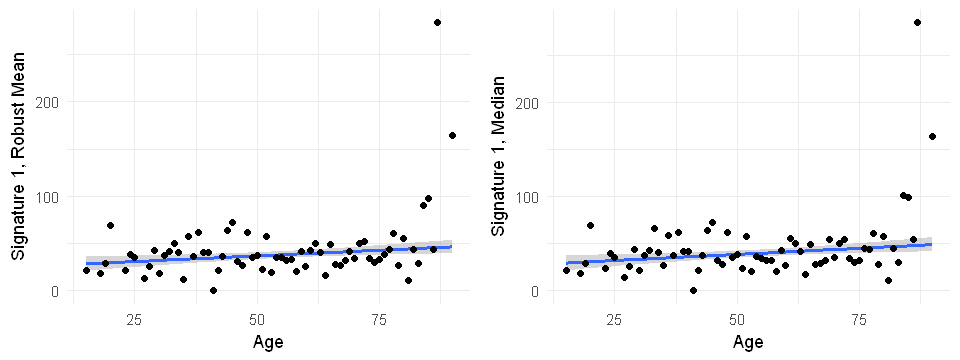

In [55]:
plot1 <- ggplot(averages, aes(Age, Sig1RobMean)) +  geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1, Robust Mean") + #scale_y_continuous(limits = c(0,500)) +
    theme_minimal()
plot2 <- ggplot(averages, aes(Age, Sig1Med)) +  geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1, Median") + #scale_y_continuous(limits = c(0,500)) +
    theme_minimal()
grid.arrange(plot1, plot2, ncol=2)

In [56]:
ggsave("linreg.png", plot=last_plot(), scale=1, width=8, height=3)

Due to the different normalization of the data and extraction of signatures, the slopes are not identical. We compute the slope of the robust regression, the spearman $\rho$ correlation. The slope is $0.32$ with P-value (Wald test) of $0.008$, while the spearman $\rho$ correlation is $0.12$ with P-value $0.032$. 

In [8]:
summary(res<-rlm(Sig1Total ~ Age, data=data.tcga))
f.robftest(res, var = "Age")


Call: rlm(formula = Sig1Total ~ Age, data = data.tcga)
Residuals:
    Min      1Q  Median      3Q     Max 
-46.906 -23.149  -5.809  21.744 231.691 

Coefficients:
            Value   Std. Error t value
(Intercept) 25.4769  6.9898     3.6449
Age          0.3179  0.1181     2.6911

Residual standard error: 33.36 on 321 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = data.tcga)
F = 7.1159, p-value = 0.008028
alternative hypothesis: true Age is not equal to 0


In [9]:
# Spearman rho
correlation.all <- cor.test(data.tcga$Age, data.tcga$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on complete dataset:", correlation.all$estimate, "with P-value", correlation.all$p.value, "\n")

Spearman correlation with age on complete dataset: 0.1195904 with P-value 0.03165921 


**TODO** Compute confidence intervals by bootstrapping (and possibly refined P-values)

**TODO** Check whether signature 7, the complete SNV count, and the SNV count without signature 1 show age dependence.

After verifying the age dependence we look at the NRAS and BRAF samples separately. At this stage we don't consider the NF1 and triple wild samples as there are not enough of them. In the graph below, each dot represents the robust mean among all samples of a given age, and the curves represent the regression curves through these means.

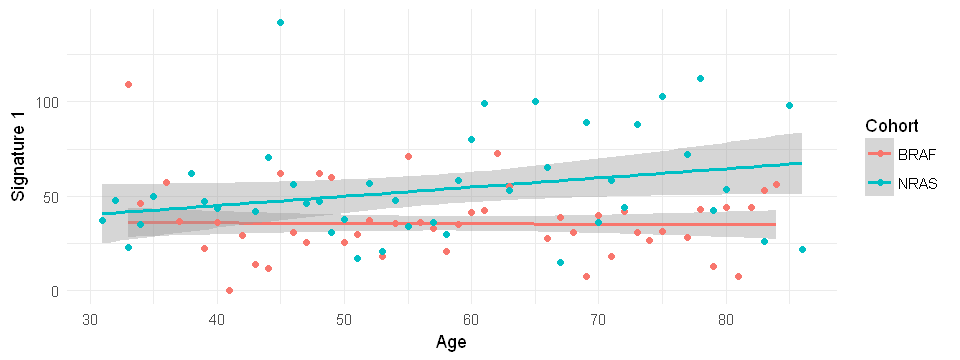

In [59]:
ggplot(subset(averages.brafnras, Age>30), aes(Age, Sig1RobMean, color=Cohort)) +  geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + #scale_y_continuous(limits = c(0,250)) +
    theme_minimal()

In [60]:
ggsave("linreg-cohort.png", plot=last_plot(), scale=1, width=8, height=3)

We repeat the analysis and compute correlation with age and robust dependence.

**BRAF**: There is no significant slope and no significant correlation.

**NRAS**: There is a slope of $0.47$ which is borderline statistically significant, but the Spearman $\rho$ correlation is not statistically significant.

In [61]:
braf <- subset(data.tcga, Cohort=="BRAF")
summary(res <- rlm(Sig1Total ~ Age, data=braf))
f.robftest(res, var = "Age")
correlation.braf <- cor.test(braf$Age, braf$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on BRAF dataset:", correlation.braf$estimate, "with P-value", correlation.braf$p.value, "\n")


Call: rlm(formula = Sig1Total ~ Age, data = braf)
Residuals:
    Min      1Q  Median      3Q     Max 
-36.382 -18.049  -4.049  19.074 189.789 

Coefficients:
            Value   Std. Error t value
(Intercept) 34.1071  6.7720     5.0365
Age          0.0555  0.1209     0.4588

Residual standard error: 27.5 on 161 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = braf)
F = 0.21146, p-value = 0.6462
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on BRAF dataset: 0.04136754 with P-value 0.6000662 


In [10]:
nras <- subset(data, Cohort=="NRAS")
summary(res <- rlm(Sig1Total ~ Age, data=nras))
f.robftest(res, var = "Age")
correlation.nras <- cor.test(nras$Age, nras$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on NRAS dataset:", correlation.nras$estimate, "with P-value", correlation.nras$p.value, "\n")


Call: rlm(formula = Sig1Total ~ Age, data = nras)
Residuals:
    Min      1Q  Median      3Q     Max 
-50.951 -24.876  -1.574  23.642 149.436 

Coefficients:
            Value   Std. Error t value
(Intercept) 29.1695 14.3028     2.0394
Age          0.4711  0.2417     1.9489

Residual standard error: 36.96 on 86 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = nras)
F = 3.8108, p-value = 0.05418
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on NRAS dataset: 0.1711595 with P-value 0.1108351 


In [11]:
nf1 <- subset(data, Cohort=="NF1")
summary(res <- rlm(Sig1Total ~ Age, data=nf1))
f.robftest(res, var = "Age")
correlation.nf1 <- cor.test(nf1$Age, nf1$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on NF1 dataset:", correlation.nf1$estimate, "with P-value", correlation.nf1$p.value, "\n")


Call: rlm(formula = Sig1Total ~ Age, data = nf1)
Residuals:
    Min      1Q  Median      3Q     Max 
-86.593 -27.715   3.528  23.459 139.215 

Coefficients:
            Value   Std. Error t value
(Intercept) 11.1703 70.2418     0.1590
Age          1.4385  0.9870     1.4574

Residual standard error: 41.09 on 19 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = nf1)
F = 2.2946, p-value = 0.1463
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on NF1 dataset: 0.3776407 with P-value 0.09145746 


In [63]:
summary(res <- rlm(Sig1RobMean ~ Age, data=averages.nras))
f.robftest(res, var = "Age")
correlation.nras <- cor.test(averages.nras$Age, averages.nras$Sig1RobMean, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on NRAS dataset:", correlation.nras$estimate, "with P-value", correlation.nras$p.value, "\n")


Call: rlm(formula = Sig1RobMean ~ Age, data = averages.nras)
Residuals:
    Min      1Q  Median      3Q     Max 
-45.510 -17.888  -1.989  13.381  94.474 

Coefficients:
            Value   Std. Error t value
(Intercept) 25.5934 15.9609     1.6035
Age          0.4874  0.2677     1.8208

Residual standard error: 26.52 on 41 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1RobMean ~ Age, data = averages.nras)
F = 3.2941, p-value = 0.07685
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on NRAS dataset: 0.2078001 with P-value 0.1811794 


**TODO** Calculate P-values by bootstrapping.

We now plot a linear regression through all the points for the different cohorts. The NF1 samples show a strong increase with age and a significantly higher mutation burden.

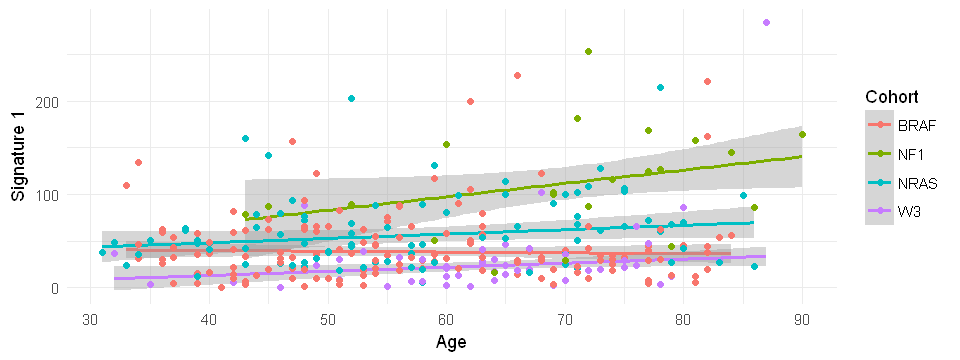

In [64]:
ggplot(subset(data.tcga, Age>30), aes(Age, Sig1Total, color=Cohort)) +  geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + #scale_y_continuous(limits = c(0,250)) +
    theme_minimal()

In [65]:
ggsave("linreg-allcohort.png", plot=last_plot(), scale=1, width=8, height=3)

In a next step, we explore the time dependence by examining the ratio of mutations to age.

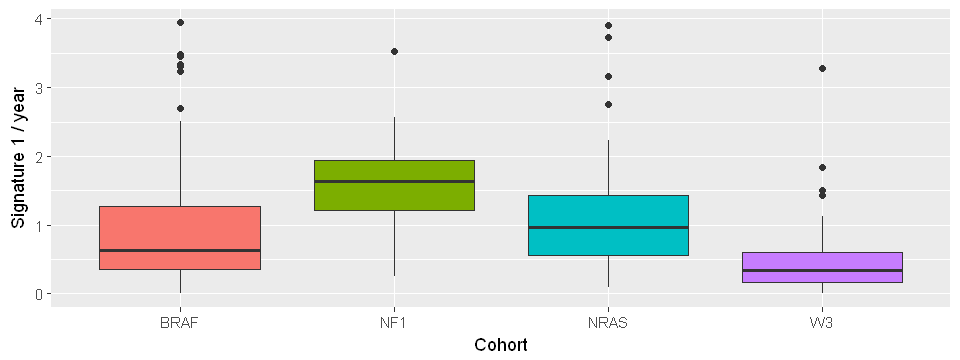

In [66]:
ggplot(data, aes(Cohort, Sig1Total/Age, fill=Cohort)) +
    geom_boxplot() + ylab("Signature 1 / year") + guides(fill=FALSE)

In [67]:
ggsave("boxplot.png", plot=last_plot(), scale=1, width=8, height=3)

In [20]:
summary(res <- rlm(Sig1Total/Age ~ Cohort, data=data))
f.robftest(res, var = "CohortNF1")
f.robftest(res, var = "CohortNRAS")
f.robftest(res, var = "CohortW3")


Call: rlm(formula = Sig1Total/Age ~ Cohort, data = data)
Residuals:
     Min       1Q   Median       3Q      Max 
-1.34108 -0.37958 -0.08216  0.40000  3.18042 

Coefficients:
            Value   Std. Error t value
(Intercept)  0.7646  0.0430    17.7734
CohortNF1    0.8365  0.1273     6.5690
CohortNRAS   0.2383  0.0727     3.2793
CohortW3    -0.3406  0.0881    -3.8655

Residual standard error: 0.5738 on 319 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total/Age ~ Cohort, data = data)
F = 41.196, p-value = 4.981e-10
alternative hypothesis: true CohortNF1 is not equal to 0



	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total/Age ~ Cohort, data = data)
F = 10.808, p-value = 0.001124
alternative hypothesis: true CohortNRAS is not equal to 0



	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total/Age ~ Cohort, data = data)
F = 15.105, p-value = 0.0001237
alternative hypothesis: true CohortW3 is not equal to 0


**TODO** Attach statistical parameters (tests) to this box plot.

**Interpretation.** If $N(t)$ denotes the number of mutations at age $t$, then estimating the expected ratio $N(t)/t$ amounts to estimating the parameter $\lambda$ for a Poisson process with offset $t$. 

### <font color="grey">  2.1 Incorporating other covariates</font>

It is interesting to compare the effect of other factors on the various analyses done so far. We first differentiate by gender. There are $33$ female and $55$ male NRAS samples, as well as $61$ female and $102$ male with BRAF mutations.

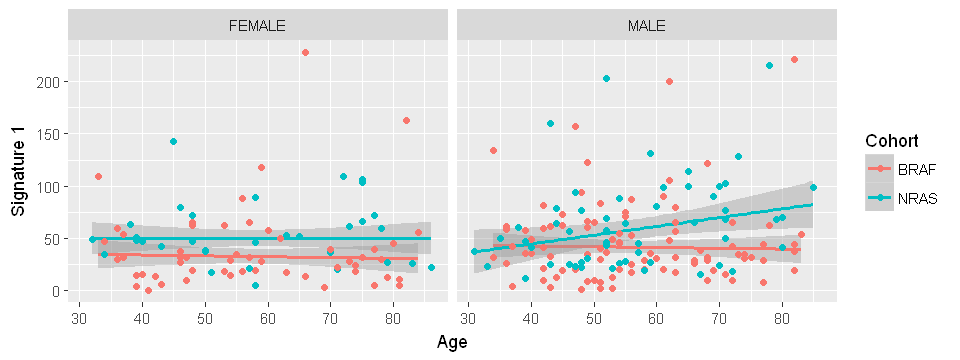

In [68]:
ggplot(subset(data, (Cohort=='BRAF' | Cohort=='NRAS') & Age>30), aes(x=Age, y=Sig1Total, color=Cohort)) +  
    geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + facet_wrap(~ Gender, ncol=2)

In [69]:
ggsave("nrasbraf-gender.png", plot=last_plot(), scale=1, width=8, height=3)

There appears to be a marked difference between the male and female in the accumulation of signatures in NRAS samples. For the male samples, we get a slope of $0.32$ (P-value 0.008) and Spearman $\rho$ correlation $0.12$ (P-value 0.032). 

In [12]:
nras.male <- subset(data, Gender=='MALE' & Cohort=="NRAS")
summary(res <- rlm(Sig1Total ~ Age, data=nras.male))
f.robftest(res, var = "Age")
correlation.nras.male <- cor.test(nras.male$Age, nras.male$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on NRAS dataset:", correlation.nras.male$estimate, "with P-value", correlation.nras.male$p.value, "\n")


Call: rlm(formula = Sig1Total ~ Age, data = nras.male)
Residuals:
    Min      1Q  Median      3Q     Max 
-55.038 -24.454  -1.144  23.037 148.233 

Coefficients:
            Value   Std. Error t value
(Intercept) 11.2185 20.9506     0.5355
Age          0.8395  0.3591     2.3375

Residual standard error: 36.31 on 53 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = nras.male)
F = 5.4388, p-value = 0.02353
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on NRAS dataset: 0.2698254 with P-value 0.04634511 


There is also a marked difference in the ratio $N(t)/t$ between genders.

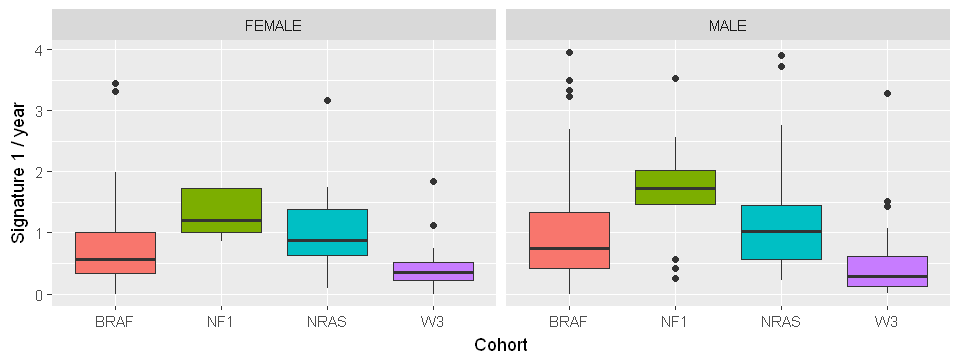

In [85]:
ggplot(data, aes(Cohort, Sig1Total/Age, fill=Cohort)) +
    geom_boxplot() + ylab("Signature 1 / year") + guides(fill=FALSE) + facet_wrap(~ Gender, ncol=2)

We now compare the samples with respect to MC1R alleles. The interesting feature of these plots is that the mutation load in the samples with one or two R-alleles seems to be uniformly higher, but with similar slope.

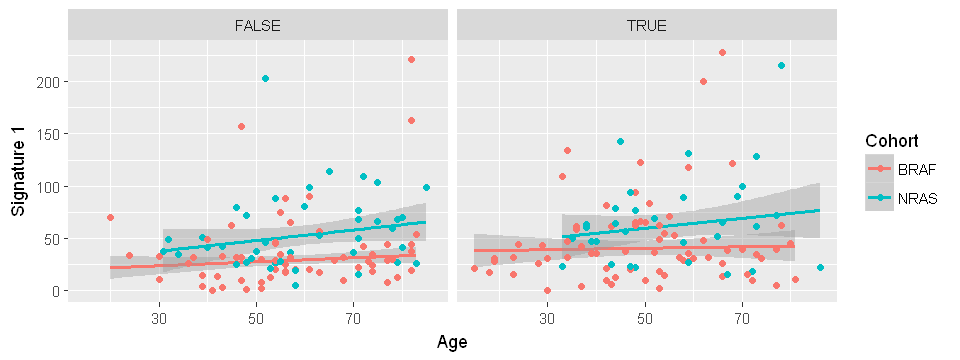

In [86]:
mydata <- subset(data, Cohort=='BRAF' | Cohort=='NRAS')
mydata <- subset(mydata, !is.na(MC1R))
mydata$Rallele <- as.factor(str_count(mydata$MC1R, 'R')>0)
ggplot(mydata, aes(x=Age, y=Sig1Total, color=Cohort)) +  
    geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + facet_wrap(~ Rallele, ncol=2)

In [87]:
ggsave("nrasbraf-mc1r.png", plot=last_plot(), scale=1, width=8, height=3)

### <font color="grey">  3. Models</font>

In order to more accurately quantify the accumulation of mutations over time, we need to make some model assumptions. While these assumptions may represent oversimplifications, they lead to systematic biases that would hold across different cohorts, and still allow to compare properties of the different types of samples to each other. **TODO** formulate this better.

For the accumulation of mutations at time $t$, [Podolskiy et al](http://www.nature.com/articles/ncomms12157) postulate the following model, assumed to be valid for a certain age range. At each age $t$, the number of muations $N(t)$ is approximately distributed according to a Poisson distribution with rate $\lambda(t)$,

\begin{equation*}
  \mtx{P}\{N(t) = n\} = \frac{\lambda(t)^n e^{-\lambda(t)}}{n!}.
\end{equation*}

While [Podolskiy et al](http://www.nature.com/articles/ncomms12157) consider the total number of mutations and argue statistically via the law of large numbers, it is reasonable to assume that the accumulation of units of signature 1 also follows a Poisson-like distribution, or a mixture of Poisson distributions with one dominant component. This component is assumed to describe the accumulation of mutations before clonal expansion, after which the dynamics change. 

**TODO** Estimate number of drivers by fitting a Poisson mixture model. May need more data / pan-cancer data for this and/or use a Bayesian approach. Topic for another paper.

Warning message in grid.Call.graphics(L_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”

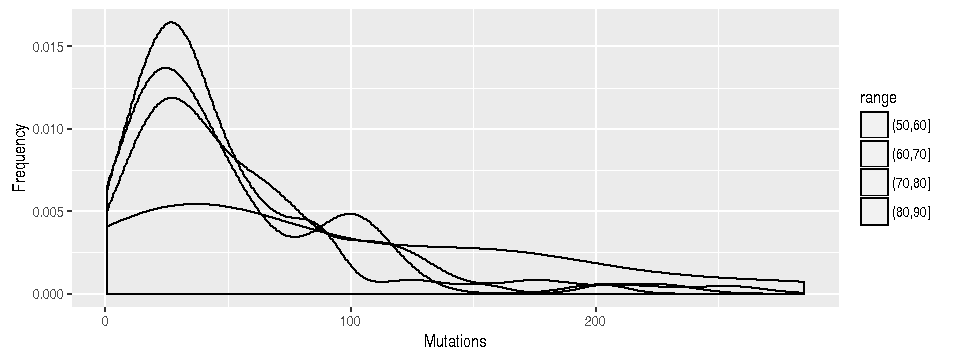

In [22]:
data$range <- cut(data$Age, c(0, 30, 40, 50, 60, 70, 80, 90), include.lowest=FALSE)
ggplot(subset(data, range != "(0,30]" & range != "(40,50]" & range != "(30,40]"), aes(x=Sig1Total, fill=range)) +
    geom_density(alpha=0.7) + xlab("Mutations") + ylab("Frequency")

In [89]:
ggsave("densities.png", plot=last_plot(), scale=1, width=8, height=3)

We can also look at the different distributions for NRAS and BRAF. 

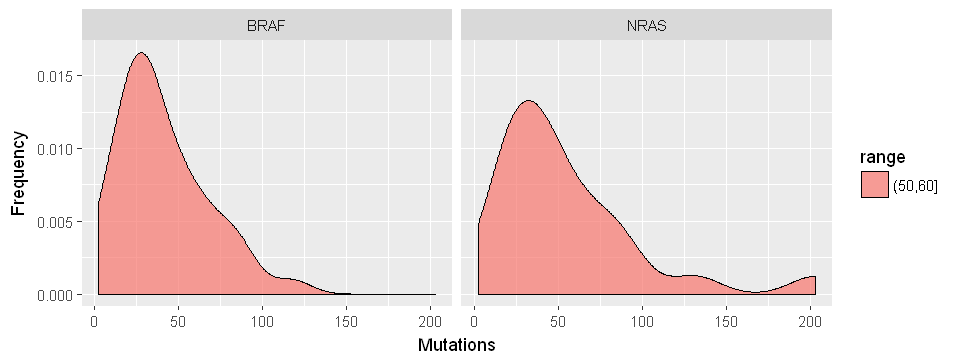

In [90]:
ggplot(subset(data, range == "(50,60]" & (Cohort=='BRAF' | Cohort=='NRAS')), aes(x=Sig1Total, fill=range)) +
    geom_density(alpha=0.7) + xlab("Mutations") + ylab("Frequency") + facet_wrap(~ Cohort, ncol=2)

In [91]:
ggsave("nrasbraf-density.png", plot=last_plot(), scale=1, width=8, height=3)

**TODO** This may be naive and difficult to test, but the number of ``peaks'' may be indicative of the number of driver mutations.

** Model 1** We first make the simplifying assumption that

1. Cells divide at a fixed expected rate $r$ divisions per year;
2. Mutations occur at a rate of $u$ mutations per gigabase pair per cell division.

Under these assumptions, the *ratio* $N/t$, follows a Poisson distribution with fixed parameter $\lambda$, though it is assumed that $\lambda$ depends on the cohort (NRAS / BRAF / NF1 / W3) and possibly other parameters. 

\begin{equation*}
  \mtx{P}\{N = tn\} = \frac{\lambda^n e^{-\lambda}}{n!},
\end{equation*}

The estimate of $\lambda$ is gained from a Poisson regression with age as offset,

\begin{equation*}
  \log \mtx{E}[N] = \log(t) + \beta_0,
\end{equation*}

where the computed intensity of the process is then $\lambda = e^{\beta_0}$. The interpretation is that the expected number of mutations at time (age) $t$ is $\lambda t = e^{\beta_0}t$. To check whether this all makes sense, we attempt a plot.

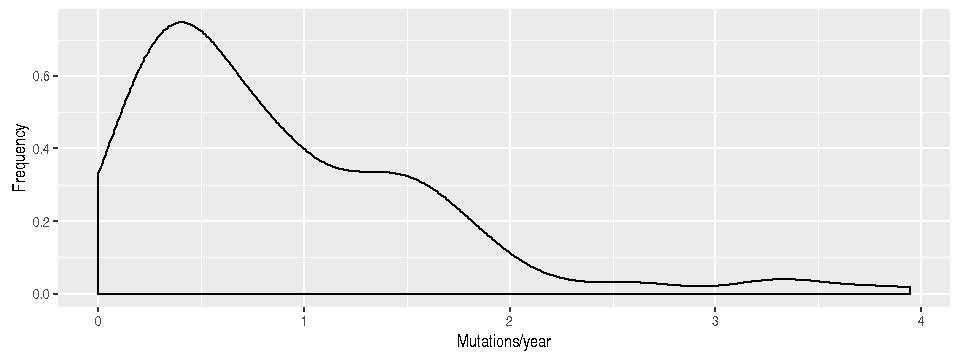

In [23]:
ggplot(subset(data, range != "(0,30]"), aes(x=Sig1Total/Age)) +
    geom_density(alpha=0.7) + xlab("Mutations/year") + ylab("Frequency")

In [24]:
ggsave("density-ratio.png", plot=last_plot(), scale=1, width=8, height=3)

We can interpret the peak as the Poisson mean for the number of mutation per year.

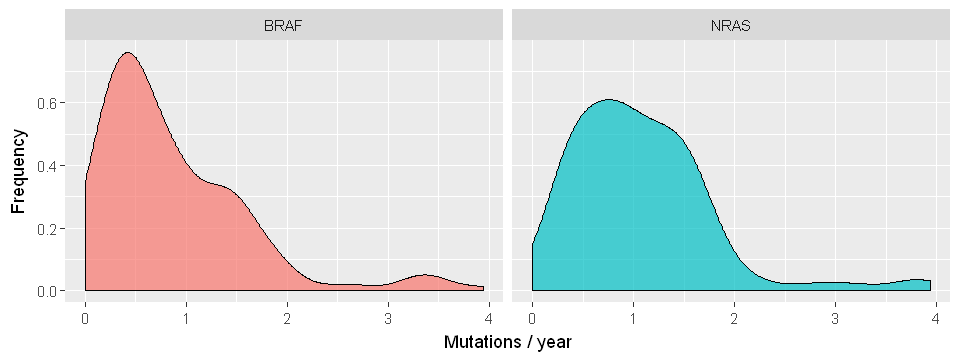

In [97]:
# Check the assumption of a Poisson distribution by dividing the different cohorts
ggplot(subset(data, Cohort=='BRAF' | Cohort=='NRAS'), aes(Sig1Total/Age, fill=Cohort)) +
    geom_density(alpha=0.7) + guides(fill=FALSE) +
    facet_wrap(~ Cohort, ncol=2) + xlab("Mutations / year") + ylab("Frequency") 

In [98]:
ggsave("ratio-density.png", plot=last_plot(), scale=1, width=8, height=3)

What we see from these plots, is that the peak for NRAS is at a higher count than that for BRAF. We also see in general 3-4 mini-peaks. We could try to make sense of these.

If we want to test model fit with other covariates, then the goal is to estimate the generalized linear model

\begin{equation*}
 \log \mtx{E}[N(t) \ | \ X_1,\dots,X_p ] = \log(t)  \beta_0 + \sum_{i=1}^p \beta_i X_i,
\end{equation*}

there the $X_i$ might represent gender, MC1R status or whether the sample has mutations in BRAF/NRAS/NF1 or none of these. Once the model is fitted, the parameter $\lambda$ follows as $\lambda = e^{\beta_0}$.

In [88]:
res.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data=data, family="poisson")
summary(res.simple)


Call:
glm(formula = as.integer(Sig1Total) ~ offset(log(Age)), family = "poisson", 
    data = data)

Deviance Residuals: 
            Min               1Q           Median               3Q  
-10.54750875515   -4.94119902118   -1.21819103716    3.07708045088  
            Max  
 18.26699664985  

Coefficients:
                     Estimate        Std. Error   z value   Pr(>|z|)    
(Intercept) -0.13739103700149  0.00788968217287 -17.41401 < 2.22e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 10408.91566107  on 322  degrees of freedom
Residual deviance: 10408.91566107  on 322  degrees of freedom
AIC: 12129.30270507

Number of Fisher Scoring iterations: 5


In [25]:
# Fit Poisson model with covariates
res <- glm(as.integer(Sig1Total) ~ offset(log(Age)) + Cohort + MC1R + Gender, data = data, family="poisson")
summary(res)


Call:
glm(formula = as.integer(Sig1Total) ~ offset(log(Age)) + Cohort + 
    MC1R + Gender, family = "poisson", data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-10.242   -4.001   -1.188    2.109   18.897  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.57326    0.02716 -21.105  < 2e-16 ***
CohortNF1    0.60290    0.02552  23.624  < 2e-16 ***
CohortNRAS   0.28422    0.02044  13.903  < 2e-16 ***
CohortW3    -0.33843    0.03265 -10.365  < 2e-16 ***
MC1Rr,0      0.16063    0.02947   5.450 5.03e-08 ***
MC1RR,0      0.25632    0.02870   8.930  < 2e-16 ***
MC1Rr,r      0.17714    0.03704   4.783 1.73e-06 ***
MC1RR,r      0.58973    0.02893  20.386  < 2e-16 ***
MC1RR,R      0.47071    0.03676  12.804  < 2e-16 ***
GenderMALE   0.12888    0.01886   6.835 8.19e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 8705.8  on 257  de

One should note that the aim of fitting the Poisson model is not to get an accurate fit of the distribution of the data (which is not Poisson in any case), but to determine the Poisson peak (mean), which should correspond to the largest mixture component of the data.

** Model 2** It has been argued by [Podolskiy et al](http://www.nature.com/articles/ncomms12157) where the expected value $\lambda(t)$ depends on age as

\begin{equation*}
  \lambda(t) = N_0 e^{\alpha t}.
\end{equation*}

Actually, the model with Poisson distribution is not completely accurate, as it measures the accumulation of mutations before clonal expansion, after which the number of mutations follows a different pattern. One might consider a more sophisticated model in a future exploration.

The value of $N_0$ and of $\alpha$ may depend on other factors, such as gender, the presence of BRAF or NRAS mutations or the presence of R alleles in the MC1R gene. We check the validity of this model in certain age ranges later on. 

In [100]:
res.exp <- glm(as.integer(Sig1Total) ~ Age, data = data, family="poisson")
res.exp.braf <- glm(as.integer(Sig1Total) ~ Age, data = subset(data, Cohort=="BRAF"), family="poisson")
res.exp.nras <- glm(as.integer(Sig1Total) ~ Age, data = subset(data, Cohort=="NRAS"), family="poisson")
N0 <- exp(coef(res.exp)["(Intercept)"])
alpha <- coef(res.exp)["Age"]
lambdas <- averages$Sig1Mean
m.av <- rollmean(lambdas, 20, na.pad=TRUE)

N0.BRAF <- exp(coef(res.exp.braf))["(Intercept)"]
N0.NRAS <- exp(coef(res.exp.nras))["(Intercept)"]
alpha.BRAF <- coef(res.exp.braf)["Age"]
alpha.NRAS <- coef(res.exp.nras)["Age"]

lambdas.braf <- averages.braf$Sig1RobMean
m.av.braf <- rollmean(lambdas.braf, 20, na.pad=TRUE)
lambdas.nras <- averages.nras$Sig1RobMean
m.av.nras <- rollmean(lambdas.nras, 20, na.pad=TRUE)

Warning message:
"Removed 2 rows containing missing values (geom_point)."Warning message:
"Removed 19 rows containing missing values (geom_path)."Warning message:
"Removed 19 rows containing missing values (geom_path)."

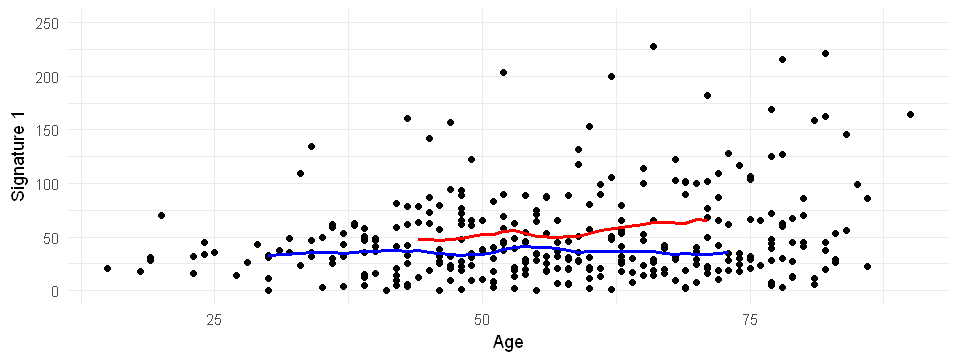

In [101]:
ggplot(data, aes(Age, Sig1Total)) + geom_point() +
    #stat_function(fun=function(x)lambda*x, geom="line", color="purple", size=1) +
    #stat_function(fun=function(x)N0.braf*exp(alpha.braf*x), geom="line", color="red", size=1) +
    geom_line(data = data.frame(x=averages.braf$Age,y=m.av.braf), aes(x,y), color="blue", size=1) +
    geom_line(data = data.frame(x=averages.nras$Age,y=m.av.nras), aes(x,y), color="red", size=1) +
    scale_color_manual("", values=c(expo="red",linear="purple",fitted="blue")) +
    xlab("Age") + ylab("Signature 1") + 
    scale_y_continuous(limits = c(0,250)) +
    #scale_x_continuous(limits = c(30,70))+
    theme_minimal()

In [102]:
res.exp.braf <- glmRob(as.integer(Sig1Total) ~ Age, data = subset(data, Cohort=="BRAF"), family="poisson")
res.exp.nras <- glmRob(as.integer(Sig1Total) ~ Age, data = subset(data, Cohort=="NRAS"), family="poisson")
summary(res.exp.braf)
summary(res.exp.nras)


Call: glmRob(formula = as.integer(Sig1Total) ~ Age, family = "poisson", 
    data = subset(data, Cohort == "BRAF"))
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-8.03073 -2.64614 -0.07342  3.66097 22.08927 

Coefficients:
             Estimate Std. Error z value Pr(>|z|)
(Intercept) 3.4372992  0.0546828 62.8589   0.0000
Age         0.0008806  0.0009729  0.9051   0.3654

(Dispersion Parameter for poisson family taken to be 1 )

    Null Deviance: 42704 on 162 degrees of freedom

Residual Deviance: 4828.171 on 161 degrees of freedom

Number of Iterations: 4 

Correlation of Coefficients:
    (Intercept)
Age -0.957     


Call: glmRob(formula = as.integer(Sig1Total) ~ Age, family = "poisson", 
    data = subset(data, Cohort == "NRAS"))
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-8.54875 -3.37107 -0.02776  3.20239 16.17540 

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  3.38410     8.1299 0.41626   0.6772
Age          0.01023     0.2581 0.03964   0.9684

(Dispersion Parameter for poisson family taken to be 1 )

    Null Deviance: 34673 on 87 degrees of freedom

Residual Deviance: 2033.024 on 86 degrees of freedom

Number of Iterations: 2 

Correlation of Coefficients:
    (Intercept)
Age -0.9999    

Suppose that at age $t$ we have $N_1(t),\dots,N_s(t)$ samples. We estimate the parameter $\lambda(t) = \lambda(t,X_1,\dots,X_p) = \mtx{E}[N(t) \ | \ X_1,\dots,X_p]$ using Poisson regression,

\begin{equation*}
  \log \mtx{E}[N(t) \ | \ X_1,\dots,X_p ] = \beta_0 + \sum_{i=1}^p \beta_i X_i,
\end{equation*}

where the $\beta_i$ are allowed to depend on $t$. In [Podolskiy et al](http://www.nature.com/articles/ncomms12157), the authors look at small time intervals and determine the Poisson peaks for each of these intervals. 
The practical problem with the approach described above is that we do not have enough data for reliably estimating Poisson average at each time. We can still try to use, for eath $t$ in a suitable range and $\Delta t$ (for example, 5 years), to use the interval $(t-\Delta t, t+\Delta t]$. A different approach would be to estimate the parameters for all times simultaneously.

However, having estimated the parameters of the model above, we can compute $N_0$ and $\alpha$ by a linear regression,

\begin{equation*}
  \log(N_0) + \alpha t = \hat{\beta}_0 + \sum_{i=1}^p \hat{\beta}_i X_i. \quad \quad [1]
\end{equation*}

There probably needs to be some statistical hacking to make this rigorous. Under the simplification assumption that $\alpha$ does not depend on the other covariates, we can just include age (time) $t$ among the dependent variables and solve a standard Poisson model,

\begin{equation*}
  \log \mtx{E}[N \ | \ t, X_1,\dots,X_p ] = \beta_0 + \alpha t + \sum_{i=1}^p \beta_i X_i,
\end{equation*}

As a first approximation, we can disregard the other covariates, and include age as covariate (rather than as time parameter). This corresponds to a "time independent" poisson "process", where time is used as covariate. The model is thus

\begin{equation*}
  \log \mtx{E}[N \ | \ X_1] = \beta_0+\beta_1X_1,
\end{equation*}

where $X_1$ corresponds to age.

In [ ]:
res.poisson <- glm(totalNonUV ~ 1 + age_at_diagnosis, data = data, family="poisson")
summary(res.poisson)

### <font color="grey">  4. Results</font>

In this section we describe what we can get quantitatively from the analysis described above.

### <font color="grey">  4.1.1 Estimating the cell division rate (linear model)</font>

We first estimate the expected mutation load using this model for the whole data, without differentiating between NRAS, BRAF, and NF1. Using the estimate of cell division rate for melanocytes from Tomasetti and Vogelstein, given as $2.48$ cell division per year, we compute the mutation rate per gigabase pair per cell division. This rate is then used later to estimate the difference in cell division rates between NRAS, BRAF, and NF1 samples.

Based on the analysis of accummulation rates, we estimate the that cells with NRAS mutation divide at a rate of approximately between $1.2$ and $1.3$ faster than cells with BRAF mutations. This remains approximately true when restricting the data to samples to different MC1R status but not gender. Here, by *mutation* we mean one unit of Signature 1 and 5 exposure. Alternative we can also count subsitutions which are not TCC>TTC (which is the dominant form in Signature 7).

Denote by $d_{\mathrm{NRAS}}$, $d_{\mathrm{BRAF}}$ and $d_{\mathrm{NF1}}$ the expected number of cell divisions per year among the cells with NRAS, with BRAF, and with NF1 mutations, respectively. As they are not exclusive, we attributed the samples with NF1 mutation and BRAF or NRAS to NF1. While we can estimate the ratio of these from the data, in order to get estimates of each one we need an estimate of the mutation rate per cell division. This can be calculated by looking at the whole dataset and using the estimate of $2.48$ division per year reported by Tomasetti and Vogelstein. Model 1 is a simple Poisson model in which the intensity $\lambda t$ changes linearly with time.

In [28]:
# Create various restricted data sets
data.age <-  subset(data, Age < 70 & Age > 30)
data.R <- subset(data, grepl("R", MC1R))
data.r <- subset(data, !grepl("R", MC1R))
data.age.R <- subset(data, Age < 70 & Age > 30 & grepl("R", MC1R))
data.age.r <- subset(data, Age < 70 & Age > 30 & !grepl("R", MC1R))
data.male <- subset(data, Gender == "MALE")
data.female <- subset(data, Gender == "FEMALE")
data.age.male <- subset(data, Gender == "MALE" & Age < 70 & Age > 30)
data.age.female <- subset(data, Gender == "FEMALE" & Age < 70 & Age > 30)
# Check the dimensions
sizes <- c(dim(data.age)[1], dim(data.R)[1], dim(data.r)[1], 
    dim(data.age.R)[1], dim(data.age.r)[1], dim(data.male)[1], dim(data.female)[1],
    dim(data.age.male)[1], dim(data.age.female)[1])
sizes

[1] 221 128 195  89 132 198 125 141  80

In [39]:
# Define a function to deal with all the different types of data sets
analyse <- function(df) {
    # Use parameter from Tomasetti-Vogelstein
    div_per_year <- 2.48
    res.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = df, family="poisson")
    lambda <- exp(coef(res.simple)["(Intercept)"])
    # Estimate mutation rate 
    u <- unname(lambda/div_per_year)
    res_braf.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(df, Cohort=="BRAF"), family="poisson")
    res_nras.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(df, Cohort=="NRAS"), family="poisson")
    res_nf1.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(df, Cohort=="NF1"), family="poisson")
    res_w3.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(df, Cohort=="W3"), family="poisson")
    lambda_nras <- exp(coef(res_nras.simple)["(Intercept)"])
    lambda_braf <- exp(coef(res_braf.simple)["(Intercept)"])
    lambda_nf1 <- exp(coef(res_nf1.simple)["(Intercept)"])
    lambda_w3 <- exp(coef(res_w3.simple)["(Intercept)"])
    div_nras <- unname(lambda_nras/u)
    div_braf <- unname(lambda_braf/u)
    div_nf1 <- unname(lambda_nf1/u)
    div_w3 <- unname(lambda_w3/u)
    ratio_nras_braf <- unname(lambda_nras/lambda_braf)
    ratio_nf1_nras <- unname(lambda_nf1/lambda_nras)
    ratio_nf1_braf <- unname(lambda_nf1/lambda_braf)
    ratio_w3_braf <- unname(lambda_w3/lambda_braf)
    # TODO: return some statistical test results
    return(c(ratio_nras_braf, ratio_nf1_braf, ratio_nf1_nras, ratio_w3_braf,
             u, div_nras, div_braf, div_nf1, div_w3))
}

In [42]:
res <- analyse(data)
res.age <- analyse(data.age)
res.R <- analyse(data.R)
res.r <- analyse(data.r)
res.age.R <- analyse(data.age.R)
res.age.r <- analyse(data.age.r)
res.male <- analyse(data.male)
res.female <- analyse(data.female)
res.age.male <- analyse(data.age.male)
res.age.female <- analyse(data.age.female)

all.data <- as.data.frame(t(matrix(c(res, res.R, res.r, res.male, res.female), ncol=5, nrow=9)))
colnames(all.data) <- c('Ratio NRAS/BRAF', 'Ratio NF1/BRAF', 'Ratio NF1/NRAS', 'Ratio W3/BRAF',
                        'Mutation rate', 'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(all.data) <- c("All", "1-2 R", "0 R", "Male", "Female")

age.data <- as.data.frame(t(matrix(c(res.age, res.age.R, res.age.r, res.age.male, res.age.female), ncol=5, nrow=9)))
colnames(age.data) <- c('Ratio NRAS/BRAF', 'Ratio NF1/BRAF', 'Ratio NF1/NRAS', 'Ratio W3/BRAF',
                        'Mutation rate', 
                        'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(age.data) <- c("All", "1-2 R", "0 R", "Male", "Female")

round(all.data, 2)
round(age.data, 2)

#write.csv(all.data, file="divrates_all.csv")
save(all.data, file="divrates_all.Rdata")
#write.csv(age.data, file="divrates_age.csv")
save(age.data, file="divrates_age.Rdata")

,Ratio NRAS/BRAF,Ratio NF1/BRAF,Ratio NF1/NRAS,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,1.31,2.02,1.54,0.62,0.35,2.96,2.25,4.56,1.39
1-2 R,1.26,1.67,1.32,0.86,0.43,2.77,2.20,3.67,1.88
0 R,1.40,2.37,1.69,0.53,0.30,3.16,2.26,5.36,1.21
Male,1.31,2.00,1.52,0.69,0.39,2.85,2.17,4.34,1.49
Female,1.32,1.86,1.41,0.57,0.29,3.17,2.41,4.48,1.37


,Ratio NRAS/BRAF,Ratio NF1/BRAF,Ratio NF1/NRAS,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,1.28,1.67,1.30,0.46,0.36,3.16,2.47,4.12,1.13
1-2 R,1.10,1.33,1.20,0.42,0.43,2.81,2.55,3.38,1.08
0 R,1.50,2.05,1.37,0.53,0.30,3.51,2.34,4.79,1.24
Male,1.28,1.68,1.32,0.37,0.37,3.10,2.43,4.09,0.90
Female,1.28,1.54,1.20,0.57,0.32,3.26,2.54,3.90,1.46


What we see from these tables is that:
1. The mutation rate per cell division is significantly higher ($1.6$ overall, $1.85$ for the age range 30-70) for samples with one or two R MC1R alleles, which confirms what is already known;
2. The estimated ratio between NRAS and BRAF profileration is about the same (around 1.3 for all ages and 1.2 when restricting the estimation to the range 30-70), except for women, where it is about the same.
3. The division rate of NF1 samples is way higher.

It should be stressed again that the sample size is rather small (for example, the age restricted female cohort consists of 44 samples), and that the estimates of mutation rate rely on the average stem cell division rate reported by Tomasetti and Vogelstein.

The mutation rate per cell division per site has been varyingly estimated to be between $10^{-10}$ and $10^{-9}$, which per gigabase ($10^9$) pair gives the right order of magnitude. We now plot the Poisson means in the age restricted data.

Warning message:
“Removed 3 rows containing missing values (geom_point).”

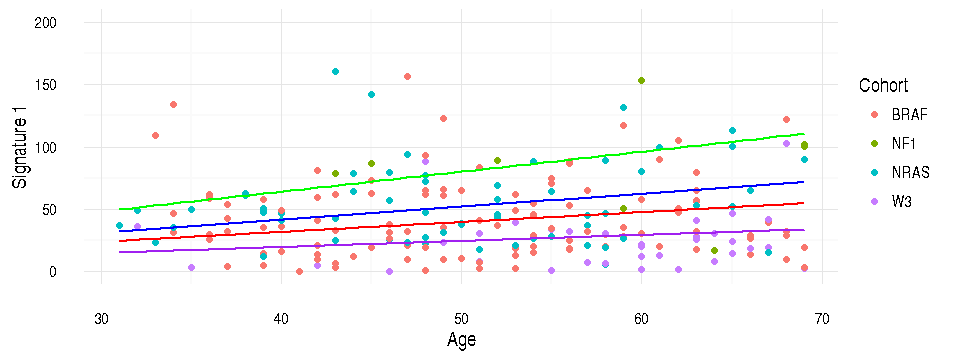

In [99]:
div_per_year <- 2.48
res.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = data, family="poisson")
lambda <- exp(coef(res.simple)["(Intercept)"])
# Estimate mutation rate 
u <- unname(lambda/div_per_year)
res_braf.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(data, Cohort=="BRAF"), family="poisson")
res_nras.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(data, Cohort=="NRAS"), family="poisson")
res_nf1.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(data, Cohort=="NF1"), family="poisson")
res_w3.simple <- glm(as.integer(Sig1Total) ~ offset(log(Age)), data = subset(data, Cohort=="W3"), family="poisson")
lambda_nras <- exp(coef(res_nras.simple)["(Intercept)"])
lambda_braf <- exp(coef(res_braf.simple)["(Intercept)"])
lambda_nf1 <- exp(coef(res_nf1.simple)["(Intercept)"])
lambda_w3 <- exp(coef(res_w3.simple)["(Intercept)"])

ggplot(data.age, aes(Age, Sig1Total, color=Cohort)) + geom_point() +
    stat_function(fun=function(x)lambda_nras*x, geom="line", color="blue") +
    xlab("Age") + ylab("Signature 1") + scale_y_continuous(limits = c(0,200)) +
    stat_function(fun=function(x)lambda_braf*x, geom="line", color="red") +
    stat_function(fun=function(x)lambda_nf1*x, geom="line", color="green") +
    stat_function(fun=function(x)lambda_w3*x, geom="line", color="purple") +
    theme_minimal()

### <font color="grey">  4.1.2 Estimating the cell division rate (exponential model)</font>

We repeat the analysis, but this time using the linearization of the exponential model, $N(t) \approx N_0+N_0\alpha t$.

In [37]:
# Define a function to deal with all the different types of data sets
analyse.linearized <- function(df) {
    # Use parameter from Tomasetti-Vogelstein
    div_per_year <- 2.48
    res.simple <- rlm(Sig1Total ~ Age, data = df)
    lambda <- coef(res.simple)["Age"]
    # Estimate mutation rate 
    u <- unname(lambda/div_per_year)
    res_braf.simple <- rlm(Sig1Total ~ Age, data = subset(df, Cohort=="BRAF"))
    res_nras.simple <- rlm(Sig1Total ~ Age, data = subset(df, Cohort=="NRAS"))
    res_nf1.simple <- rlm(Sig1Total ~ Age, data = subset(df, Cohort=="NF1"))
    res_w3.simple <- rlm(Sig1Total ~ Age, data=subset(df, Cohort=="W3"))
    lambda_nras <- coef(res_nras.simple)["Age"]
    lambda_braf <- coef(res_braf.simple)["Age"]
    lambda_nf1 <- coef(res_nf1.simple)["Age"]
    lambda_w3 <- coef(res_w3.simple)["Age"]
    div_nras <- unname(lambda_nras/u)
    div_braf <- unname(lambda_braf/u)
    div_nf1 <- unname(lambda_nf1/u)
    div_w3 <- unname(lambda_w3/u)
    ratio_nras_braf <- unname(lambda_nras/lambda_braf)
    ratio_nf1_nras <- unname(lambda_nf1/lambda_nras)
    ratio_nf1_braf <- unname(lambda_nf1/lambda_braf)
    ratio_w3_braf <- unname(lambda_w3/lambda_braf)
    # TODO: return some statistical test results
    return(c(ratio_nras_braf, ratio_nf1_braf, ratio_nf1_nras, ratio_w3_braf, u, div_nras, div_braf, div_nf1, div_w3))
}

In [ ]:
# Define a function to deal with all the different types of data sets
analyse.exp <- function(df) {
    # Use parameter from Tomasetti-Vogelstein
    div_per_year <- 2.48
    res.simple <- glm(as.integer(Sig1Total) ~ Age, data = df, family="poisson")
    N <- exp(coef(res.simple)["(Intercept)"])
    alpha <- coef(res.simple)["Age"]
    lambda <- N*alpha
    # Estimate mutation rate 
    u <- unname(lambda/div_per_year)
    res_braf.simple <- glm(as.integer(Sig1Total) ~ Age, data = subset(df, Cohort=="BRAF"), family="poisson")
    res_nras.simple <- glm(as.integer(Sig1Total) ~ Age, data = subset(df, Cohort=="NRAS"), family="poisson")
    res_nf1.simple <- glm(as.integer(Sig1Total) ~ Age, data = subset(df, Cohort=="NF1"), family="poisson")
    res_w3.simple <- glm(as.integer(Sig1Total) ~ Age, data = subset(df, Cohort=="W3"), family="poisson")
    N_nras <- exp(coef(res_nras.simple)["(Intercept)"])
    N_braf <- exp(coef(res_braf.simple)["(Intercept)"])
    N_nf1 <- exp(coef(res_nf1.simple)["(Intercept)"])
    N_w3 <- exp(coef(res_w3.simple)["(Intercept)"])
    
    div_nras <- unname(lambda_nras/u)
    div_braf <- unname(lambda_braf/u)
    div_nf1 <- unname(lambda_nf1/u)
    div_w3 <- unname(lambda_w3/u)
    ratio_nras_braf <- unname(lambda_nras/lambda_braf)
    ratio_nf1_nras <- unname(lambda_nf1/lambda_nras)
    ratio_nf1_braf <- unname(lambda_nf1/lambda_braf)
    ratio_w3_braf <- unname(lambda_w3/lambda_braf)
    # TODO: return some statistical test results
    return(c(ratio_nras_braf, ratio_nf1_braf, ratio_nf1_nras, ratio_w3_braf, u, div_nras, div_braf, div_nf1, div_w3))
}

In [38]:
res.lin <- analyse.linearized(data)
res.age.lin <- analyse.linearized(data.age)
res.R.lin <- analyse.linearized(data.R)
res.r.lin <- analyse.linearized(data.r)
res.age.R.lin <- analyse.linearized(data.age.R)
res.age.r.lin <- analyse.linearized(data.age.r)
res.male.lin <- analyse.linearized(data.male)
res.female.lin <- analyse.linearized(data.female)
res.age.male.lin <- analyse.linearized(data.age.male)
res.age.female.lin <- analyse.linearized(data.age.female)

all.data.lin <- as.data.frame(t(matrix(c(res.lin, res.R.lin, res.r.lin, res.male.lin, res.female.lin), ncol=5, nrow=9)))
colnames(all.data.lin) <- c('Ratio NRAS/BRAF', 'Ratio NF1/NRAS', 'Ratio NF1/BRAF', 'Ratio W3/BRAF', 
                            'Mutation rate', 'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(all.data.lin) <- c("All", "1-2 R", "0 R", "Male", "Female")

age.data.lin <- as.data.frame(t(matrix(c(res.age.lin, res.age.R.lin, res.age.r.lin, res.age.male.lin, res.age.female.lin), ncol=5, nrow=9)))
colnames(age.data.lin) <- c('Ratio NRAS/BRAF', 'Ratio NF1/NRAS', 'Ratio NF1/BRAF', 'Ratio W3/BRAF', 'Mutation rate', 
                            'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(age.data.lin) <- c("All", "1-2 R", "0 R", "Male", "Female")

round(all.data.lin, 2)
round(age.data.lin, 2)

write.csv(all.data.lin, file="divrates_all_lin.csv")
write.csv(age.data.lin, file="divrates_age_lin.csv")

Warning message in rlm.default(x, y, weights, method = method, wt.method = wt.method, :
“'rlm' failed to converge in 20 steps”

,Ratio NRAS/BRAF,Ratio NF1/NRAS,Ratio NF1/BRAF,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,8.49,25.93,3.05,4.91,0.13,3.68,0.43,11.22,2.13
1-2 R,6.81,26.55,3.90,18.46,0.24,1.96,0.29,7.65,5.32
0 R,4.75,7.53,1.59,0.67,0.10,5.85,1.23,9.28,0.82
Male,15.49,29.61,1.91,17.42,0.23,3.64,0.24,6.96,4.10
Female,0.07,26.54,359.46,-2.65,0.03,0.12,1.57,41.71,-4.16


,Ratio NRAS/BRAF,Ratio NF1/NRAS,Ratio NF1/BRAF,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,5.77,6.27,1.09,2.03,0.00,-167.42,-29.03,-181.98,-59.08
1-2 R,-10.17,-20.36,2.00,-25.32,0.09,4.48,-0.44,8.97,11.16
0 R,2.82,-9.72,-3.44,-0.82,-0.04,-21.10,-7.48,72.67,6.11
Male,36.55,24.08,0.66,16.66,0.08,13.88,0.38,9.14,6.33
Female,-1.66,-45.83,27.61,0.03,-0.11,1.83,-1.10,50.43,-0.04


The results don't look like anything we should include.

### <font color="grey">  4.2 The Tomasetti-Vogelstein graph</font>

The difference between the cell proliferation rates estimated does not appear to be enough to significantly change the position on the graph relating cumulative number of cell divisions to lifetime risk from [Tomasetti and Vogelstein](http://science.sciencemag.org/content/347/6217/78). It is unclear whether a more precise analysis will make a difference here, as the calculations by Tomasetti and Vogelstein are extremely unprecise and based on very rough estimates.

To be precise, Tomasetti and Vogelstein calculate the number of total stem cell divisions in the lifetime of a tissue (lscd) as

\begin{equation*}
  \mathrm{lscd} = s\cdot (2+80d)-2,
\end{equation*}

where $s$ is the total number of cells in the tissue and $d$ is the number of cell divisions per year (so that $80\cdot d$ is the number of cell divisions in an $80$ year lifetime). The plot the lifetime risk of each cancer type $r$ agains its $\mathrm{lscd}$. To determine which types have a significant intrinsic or extrinsic contribution, they compute the (adjusted) Extra Risk Score (aERS), as

\begin{equation*}
  \mathrm{aERS} = 18.49 + \log_{10}(r) \log_{10}(\mathrm{lscd}) \quad \quad [1]
\end{equation*}

In the case of melanoma, they get a value of $-1.62$, which relativises environmental contributions. Which parameters in [1] would have to change in which way in order to get a positive value? Assuming that 50% of melanomas have BRAF mutations and 20% NRAS, the corresponding lifetime risk would be $0.5r$ and $0.2r$, making the $\log_{10}(r)$ term even smaller. In the other logarithm, replacing $d$ with the NRAS and BRAS specific values obtained above is not enough to compensate for this. However, what also changes with the cell division rate is the total number of cells $s$ of candidate cells for NRAS or BRAF. In order to make [1] positive, these would have to be rather extreme.

The following plot shows what the proportion of the total melanocyte population attributed to candidate cells for BRAF mutations would have to be as a function of cell division rate in order to get an aERS of $0$. The area under the curve corresponds to the combinations of division rate and tissue size that, according to the Tomasetti-Vogelstein formula, would place that type of melanoma on the side of cancers with significant extrinsic contribution.

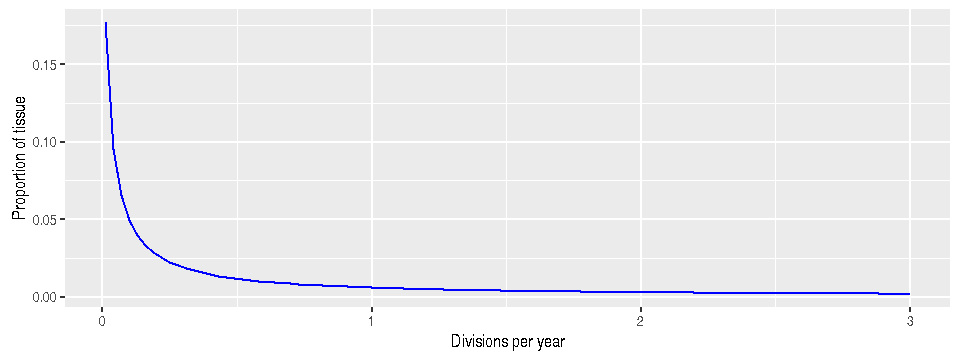

In [104]:
tissue.size <- function(x) {
    return((10^(-18.49/log10(0.5*0.0203))/3.8e9)/(2+80*x))
}
ggplot(data.frame(x = c(0.01,3)), aes(x)) + stat_function(fun = tissue.size, geom = "line", color="blue") + 
  xlab("Divisions per year") + ylab("Proportion of tissue")

Example: $r_{\mathrm{BRAF}} = 0.5 r$, $d_{\mathrm{BRAF}} = 1$ (one cell division per year), $s_{\mathrm{BRAF}} = 0.01s$ (only one in 100 melanocytes are susceptible to BRAF mutations). Then

\begin{equation*}
  \mathrm{aERS} = 18.49 + \log_{10}(0.5 r) \log_{10}(0.01s(82)-2) = -0.44,
\end{equation*}

which would still place these on the "back luck" side of the classification. 

We can also figure out the potential position of BRAF and NRAS on the Tomasetti-Vogelstein graph as a function of total tissue size.

Warning message in grid.Call.graphics(L_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”

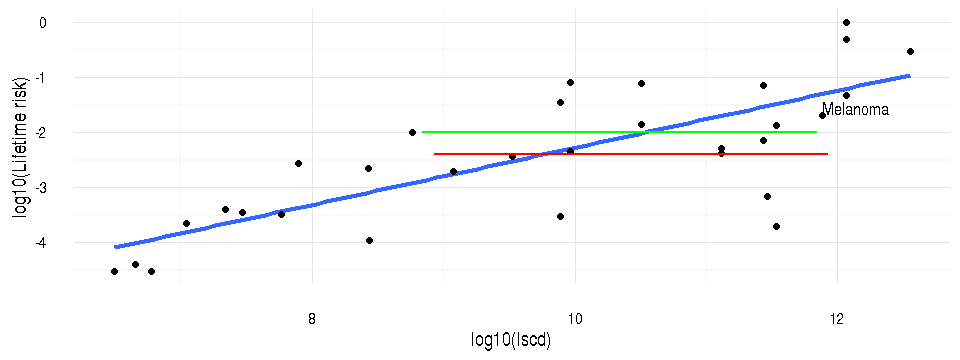

In [100]:
df <- read.csv('data/s1-vogelstein.csv', header=TRUE)
tv <- data.frame(df$X,df$Lifetime.cancer.risk)
tv$lscd <- df[,ncol(df)]

s <- 3.8e9
r <- 0.0203
r.nras <- 0.2*r
r.braf <- 0.5*r
d.nras <- 2.77
d.braf <- 2.27

lscd.fun.nras <- function(delta) {
    return(delta*s*(80*d.nras+2)-2)
}

lscd.fun.braf <- function(delta) {
    return(delta*s*(80*d.braf+2)-2)
}

ggplot(tv, aes(log10(lscd), log10(df.Lifetime.cancer.risk))) +  geom_smooth(method = "lmrob") + geom_point() +
    xlab("log10(lscd)") + ylab("log10(Lifetime risk)") + 
    geom_text(aes(label=ifelse(row.names(tv)==19,as.character(df.X),'')),hjust=0, vjust=0) + 
    geom_segment(aes(x = log10(lscd.fun.nras(0.001)), y=log10(r.nras), xend = log10(lscd.fun.nras(1)), yend = log10(r.nras)), color = "red") +
geom_segment(aes(x = log10(lscd.fun.braf(0.001)), y=log10(r.braf), xend = log10(lscd.fun.braf(1)), yend = log10(r.braf)), color = "green") +  
theme_minimal()

The green line give the range of positions for BRAF as the tissue size varies from $0.001s$ to $s$, where $s$ is the total tissue size of melanocytes estimated by Tomasetti and Vogelstein. The red line does the same with NRAS.

### <font color="grey">  4.3 Estimating the number of driver mutations</font>

It remains to look at the analysis of [Wu et al](http://www.nature.com/nature/journal/v529/n7584/full/nature16166.html). As I don't have any reasonable estimates about the proportion of total tissue susceptible to NRAS or BRAF mutations (is there experimental work on this?), I can't make any sensible calculations of theoretical lifetime intrinsic risk (tLIR), as done by Wu et al. One can, however, use their model to estimate how the number of required hits $k$ depends on the cell division rate. 

Assume that $k$ hits (driver mutations) are needed for the onset of cancer, and that each of these occurs with a probability of $p$ during cell division. The number of cell generations $X$ until we reach $k$ driver mutations follows a [negative binomial distrubtion](https://en.wikipedia.org/wiki/Negative_binomial_distribution),

\begin{equation*}
  \mathbf{P}\{ X=n \} = \binom{n-1}{k-1}p^k(1-p)^{n-k},
\end{equation*}

and the expected value of this distribution (= expected number of generations until $k$ hits) is known to be

\begin{equation*}
  \mathbf{E}[X] = \frac{(1-p)k}{p^2}.
\end{equation*}

The total number of cell division at age $t$ is $d\cdot t$, where $d$ is the division rate per year.
The average age of the NRAS samples is $58$, while that of the BRAF samples is $50$. We therefore get for the ratio of the expected number of hits:

\begin{equation*}
  \frac{k_{\mathrm{NRAS}}}{k_{\mathrm{BRAF}}} = \frac{58 d_{\mathrm{NRAS}}}{50 d_{\mathrm{BRAF}}} =  1.41
\end{equation*}

This confirms that NRAS requires more hits than BRAF (but note again that this is a ``back of the envelope'' computation that is based on simplifications).

### <font color="grey">  4.4 Other considerations</font>

Some things to consider:
1. The mutation load seems to vary with age. In particular, the increase is slightly exponential in mid-age, and slows down at higher ages. Is this due to changes in mutation frequency or in cell division rate?
2. Certain mutations can increase the mutation frequency, while others may lead to an increase in proliferation. 
3. Perform goodness-of-fit tests, test for over- or under dispersion and use negative binomial models instead, etc. Include confidence intervals and P values in everything.
4. Get larger datasets / datasets for validation.
5. Get more precise information on some of the parameters involved.
6. Include more parameters / covariates in the analysis.

These would require reading one or two piles of papers before proceeding.
* Look at more refined models for the accumulation of mutations. Examples include [Bozic et al](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004731), [Bozic et al](http://www.pnas.org/content/107/43/18545.abstract), [Keller and Antal](http://iopscience.iop.org/article/10.1088/1742-5468/2015/01/P01011/meta), [Paterson, Nowak and Waclaw](http://www.nature.com/articles/srep39511as), as well as related work from the group of [Martin Nowak](http://ped.fas.harvard.edu/).
* Look at material on the proliferation of cells in order to deduce some conclusions from the estimated cell division rates. Possible sources to look at include in [Cichorek et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3834696/), [Whiteman et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3395885/), [Zabierowski et al](https://www.ncbi.nlm.nih.gov/pubmed/21410654), [Hoek and Goding](https://www.ncbi.nlm.nih.gov/pubmed/20726948), and [Schatton and Frank](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2885609/). 
* Double wild types

### <font color="grey">  5. Validation: ICGC data and alternative signature extraction</font>

We repeat some of the analysis using data from Melanoma Australia, provided by ICGC. The data consists of $119$ samples for which complete age information was available. While the amount of data is not enough for a precise quantitative comparison, we verified that the results are qualitatively consistent with what was previously found.

We added information on whether the sample had mutations in BRAF, NRAS, NF1 or none of these genes. Overall, $54$ samples are BRAF, $41$ samples NRAS, $12$ samples NF1, and the remaining $12$ samples were classified as triple wild type (W3).

Plotting the robust linear regression of the different cohorts give a picture that appears consistent with the exome data from TCGA.

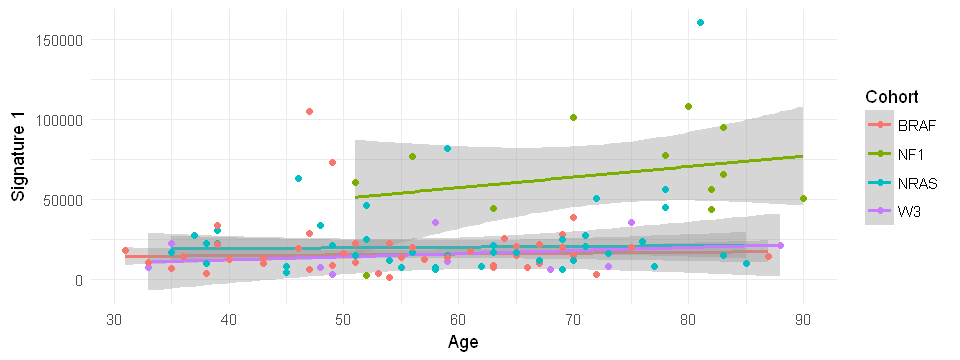

In [39]:
ggplot(subset(data.icgc, Age>30), aes(Age, Sig1Total, color=Cohort)) +  geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + #scale_y_continuous(limits = c(0,250)) +
    theme_minimal()

Computing the Spearman $\rho$ correlation shows that there is a statistically significant correlation between the signature 1 exposure and age.

In [40]:
summary(res<-rlm(Sig1Total ~ Age, data=data.icgc))
f.robftest(res, var = "Age")
# Spearman rho
correlation.all <- cor.test(data.icgc$Age, data.icgc$Sig1Total, method="spearman", alternative="two.sided", exact=FALSE)
cat("Spearman correlation with age on complete dataset:", correlation.all$estimate, "with P-value", correlation.all$p.value, "\n")


Call: rlm(formula = Sig1Total ~ Age, data = data.icgc)
Residuals:
   Min     1Q Median     3Q    Max 
-21331  -9189  -1860  10244 134634 

Coefficients:
            Value     Std. Error t value  
(Intercept) 8527.4629 4332.0017     1.9685
Age          217.4851   75.0486     2.8979

Residual standard error: 14390 on 117 degrees of freedom


	robust F-test (as if non-random weights)

data:  from rlm(formula = Sig1Total ~ Age, data = data.icgc)
F = 8.081, p-value = 0.00528
alternative hypothesis: true Age is not equal to 0


Spearman correlation with age on complete dataset: 0.2175342 with P-value 0.01747763 


Comparing the ratio of Signature 1 exposure to age also gives a similar overall picture, though the difference between NRAS and BRAF looks less marked.

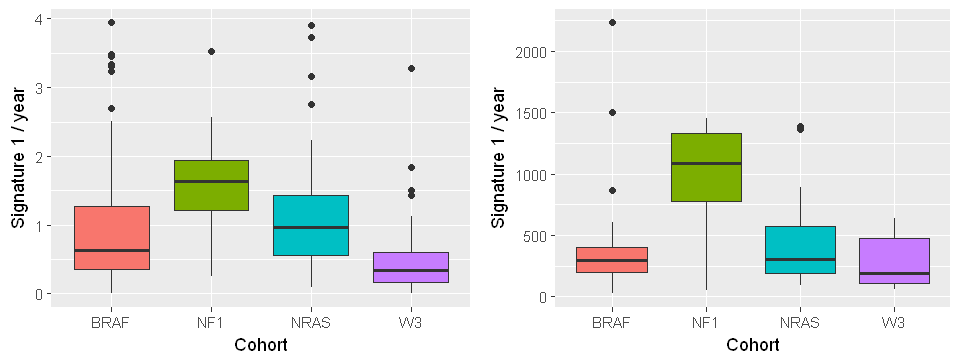

In [41]:
plot1 <- ggplot(data, aes(Cohort, Sig1Total/Age, fill=Cohort)) +
    geom_boxplot() + ylab("Signature 1 / year") + guides(fill=FALSE)
plot2 <- ggplot(subset(data.icgc, Age>30 & Age<80), aes(Cohort, Sig1Total/Age, fill=Cohort)) +
    geom_boxplot() + ylab("Signature 1 / year") + guides(fill=FALSE)
grid.arrange(plot1, plot2, ncol=2)

We can also verify a similar behaviour of there being a difference in mutation accumulation between Male and Female samples with respect to NRAS.

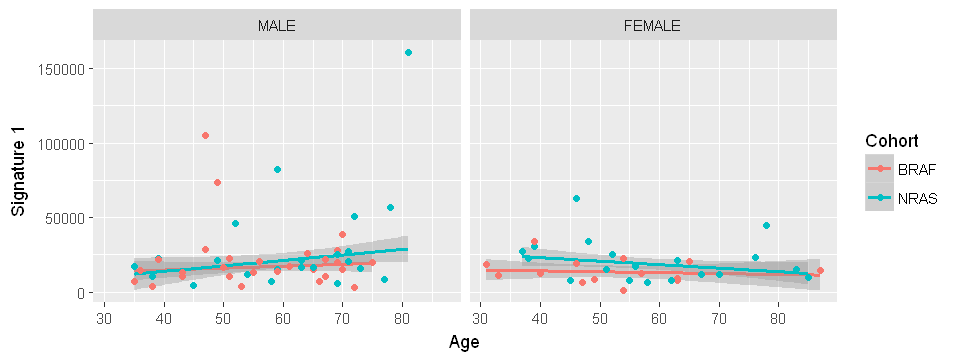

In [42]:
ggplot(subset(data.icgc, (Cohort=='BRAF' | Cohort=='NRAS') & Age>30), aes(x=Age, y=Sig1Total, color=Cohort)) +  
    geom_smooth(method = "rlm") + geom_point() +
    xlab("Age") + ylab("Signature 1") + facet_wrap(~ Gender, ncol=2)

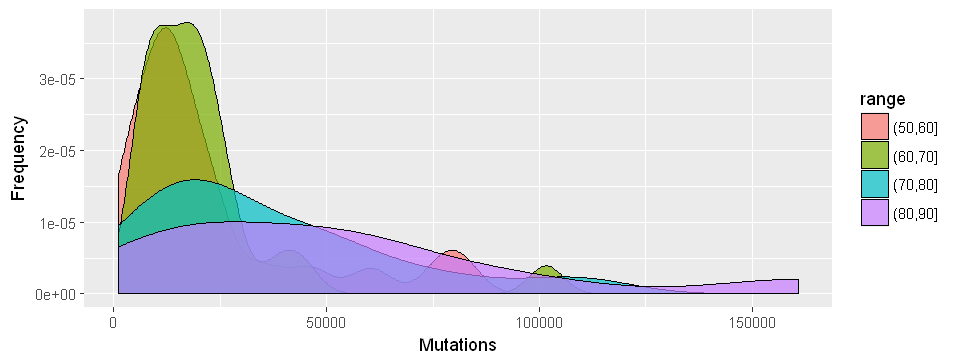

In [38]:
data.icgc$range <- cut(data.icgc$Age, c(0, 30, 40, 50, 60, 70, 80, 90), include.lowest=FALSE)
ggplot(subset(data.icgc, range != "(0,30]" & range != "(40,50]" & range != "(30,40]"), aes(x=Sig1Total, fill=range)) +
    geom_density(alpha=0.7) + xlab("Mutations") + ylab("Frequency")

In [43]:
data <- data.icgc

In [44]:
# Create various restricted data sets
data.age <-  subset(data, Age < 70 & Age > 30)
data.male <- subset(data, Gender == "MALE")
data.female <- subset(data, Gender == "FEMALE")
data.age.male <- subset(data, Gender == "MALE" & Age < 70 & Age > 30)
data.age.female <- subset(data, Gender == "FEMALE" & Age < 70 & Age > 30)
# Check the dimensions
sizes <- c(dim(data.age)[1], dim(data.male)[1], dim(data.female)[1],
    dim(data.age.male)[1], dim(data.age.female)[1])
sizes

[1] 77 77 42 48 29

In [46]:
res <- analyse(data)
res.age <- analyse(data.age)
res.male <- analyse(data.male)
res.female <- analyse(data.female)
res.age.male <- analyse(data.age.male)
res.age.female <- analyse(data.age.female)

all.data.icgc <- as.data.frame(t(matrix(c(res, res.male, res.female), ncol=3, nrow=9)))
colnames(all.data.icgc) <- c('Ratio NRAS/BRAF', 'Ratio NF1/BRAF', 'Ratio NF1/NRAS', 'Ratio W3/BRAF',
                        'Mutation rate', 'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(all.data.icgc) <- c("All", "Male", "Female")

age.data.icgc <- as.data.frame(t(matrix(c(res.age, res.age.male, res.age.female), ncol=3, nrow=9)))
colnames(age.data.icgc) <- c('Ratio NRAS/BRAF', 'Ratio NF1/BRAF', 'Ratio NF1/NRAS', 'Ratio W3/BRAF',
                        'Mutation rate', 
                        'Division rate NRAS', 'Division rate BRAF', 'Division rate NF1', 'Division rate W3')
rownames(age.data.icgc) <- c("All", "Male", "Female")

round(all.data.icgc, 2)
round(age.data.icgc, 2)

#write.csv(all.data, file="divrates_all.csv")
save(all.data.icgc, file="divrates_all_icgc.Rdata")
#write.csv(age.data, file="divrates_age.csv")
save(age.data.icgc, file="divrates_age_icgc.Rdata")

,Ratio NRAS/BRAF,Ratio NF1/BRAF,Ratio NF1/NRAS,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,1.10,2.28,2.06,0.94,191.63,2.27,2.06,4.69,1.93
Male,1.12,2.29,2.05,0.98,216.74,2.29,2.04,4.68,1.99
Female,1.27,2.35,1.86,0.62,146.93,2.47,1.95,4.59,1.21


,Ratio NRAS/BRAF,Ratio NF1/BRAF,Ratio NF1/NRAS,Ratio W3/BRAF,Mutation rate,Division rate NRAS,Division rate BRAF,Division rate NF1,Division rate W3
All,1.10,2.26,2.05,0.72,160.53,2.52,2.29,5.17,1.66
Male,0.97,2.62,2.70,0.75,176.31,2.25,2.32,6.06,1.74
Female,1.46,0.17,0.12,0.33,133.31,3.11,2.13,0.36,0.71


These would require reading one or two piles of papers before proceeding.
* Look at more refined models for the accumulation of mutations. Examples include [Bozic et al](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004731), [Bozic et al](http://www.pnas.org/content/107/43/18545.abstract), [Keller and Antal](http://iopscience.iop.org/article/10.1088/1742-5468/2015/01/P01011/meta), [Paterson, Nowak and Waclaw](http://www.nature.com/articles/srep39511as), as well as related work from the group of [Martin Nowak](http://ped.fas.harvard.edu/).
* Look at material on the proliferation of cells in order to deduce some conclusions from the estimated cell division rates. Possible sources to look at include in [Cichorek et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3834696/), [Whiteman et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3395885/), [Zabierowski et al](https://www.ncbi.nlm.nih.gov/pubmed/21410654), [Hoek and Goding](https://www.ncbi.nlm.nih.gov/pubmed/20726948), and [Schatton and Frank](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2885609/). 
* Double wild types